In [1]:
import pandas as pd
import numpy as np
import matplotlib .pyplot as plt

In [3]:
data= pd.read_csv('tesla.csv')
data.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [3]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [4]:
data.shape

(1692, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


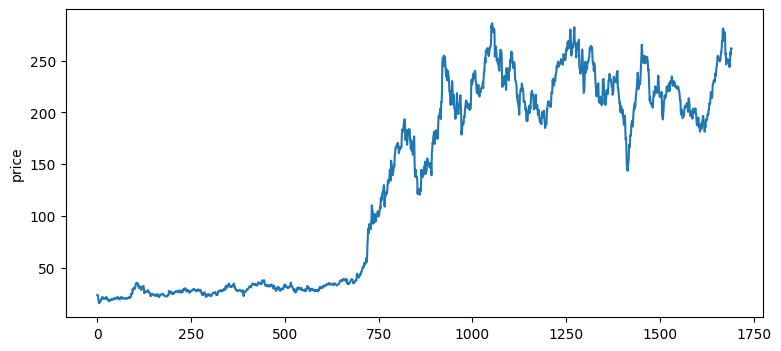

In [6]:
plt.figure(figsize=(9,4))
plt.plot(data['Close'])
plt.ylabel('price')
plt.show()

In [5]:

import pandas as pd
import numpy as np

# Step 1: Load dataset
data = pd.read_csv("tesla.csv")
data['Close'] = data['Close'].fillna(data['Close'].mean())
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
X = data[features].values
y = data['Target'].values

# Step 2: Standard Scaling
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1
X_scaled = (X - X_mean) / X_std

# Step 3: PCA
cov_matrix = np.cov(X_scaled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
sorted_idx = np.argsort(eigenvalues)[::-1]
principal_components = eigenvectors[:, sorted_idx[:2]]
X_pca = np.dot(X_scaled, principal_components)

# Step 4: Train-test split
split = int(0.8 * len(X_pca))
X_train, X_test = X_pca[:split], X_pca[split:]
y_train, y_test = y[:split], y[split:]

# Step 5: Manual Decision Tree Regressor
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def mse(y):
    if len(y) == 0:
        return 0
    return np.mean((y - np.mean(y)) ** 2)

def split(X, y, feature, threshold):
    left_idx = X[:, feature] <= threshold
    right_idx = X[:, feature] > threshold
    return X[left_idx], y[left_idx], X[right_idx], y[right_idx]

def best_split(X, y):
    min_mse = float('inf')
    best_feat, best_thresh = None, None

    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for t in thresholds:
            X_l, y_l, X_r, y_r = split(X, y, feature, t)
            if len(y_l) == 0 or len(y_r) == 0:
                continue
            mse_split = (len(y_l) / len(y)) * mse(y_l) + (len(y_r) / len(y)) * mse(y_r)
            if mse_split < min_mse:
                min_mse = mse_split
                best_feat = feature
                best_thresh = t
    return best_feat, best_thresh

def build_tree(X, y, depth=0, max_depth=5):
    if len(np.unique(y)) == 1 or depth >= max_depth:
        return TreeNode(value=np.mean(y))

    feat, thresh = best_split(X, y)
    if feat is None:
        return TreeNode(value=np.mean(y))

    X_l, y_l, X_r, y_r = split(X, y, feat, thresh)
    left = build_tree(X_l, y_l, depth+1, max_depth)
    right = build_tree(X_r, y_r, depth+1, max_depth)
    return TreeNode(feature=feat, threshold=thresh, left=left, right=right)

def predict_single(x, node):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_single(x, node.left)
    else:
        return predict_single(x, node.right)

def predict(X, tree):
    return [predict_single(x, tree) for x in X]

# Step 6: Train and predict
tree = build_tree(X_train, y_train, max_depth=5)
y_pred = predict(X_test, tree)

# Step 7: Evaluation
def evaluate_regression(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    return mse, mae, r2

mse, mae, r2 = evaluate_regression(y_test, y_pred)

print("Manual Decision Tree Regression with PCA:")
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")



Manual Decision Tree Regression with PCA:
MSE: 67.92, MAE: 6.44, R²: 0.89


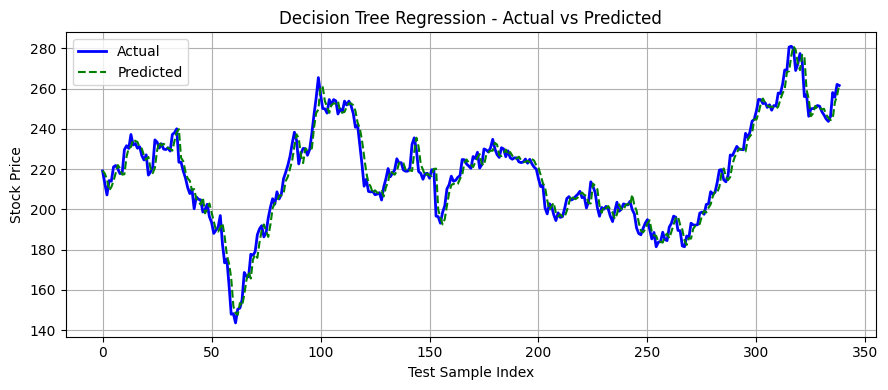

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue', linewidth=2)
plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='green', linestyle='--')
plt.xlabel('Test Sample Index')
plt.ylabel('Stock Price')
plt.title('Decision Tree Regression - Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
